# Notebook corresponding to case studies taken from MaveDB

In [1]:
from pathlib import Path

In [2]:
import os
base_path = Path("/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)")
list(base_path.glob("*.csv"))[:5]

[PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_003110.1.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_005076.3.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_005493.2.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_057097.2.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_055790.1.csv')]

In [3]:
import pandas as pd
# Use a generator expression to read and concatenate CSVs
df = pd.concat((pd.read_csv(file) for file in base_path.rglob("*.csv")), ignore_index=True)
# df = pd.read_csv('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_055790.1.csv')
df[df["DMS_bin_score"] == "Benign"]

,Unnamed: 0,protein,protein_sequence,mutant,mutated_sequence,DMS_bin_score
0,67567,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,R13G,MAVLLLLLRALRGGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign
1,67568,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,G32E,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPEFPARPGRGRPYMAS...,Benign
2,67569,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,K113R,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign
5,67572,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,V183I,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign
6,67573,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,R294H,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign
...,...,...,...,...,...,...
62715,18955,NP_004647.1,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,S596G,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,Benign
62717,18957,NP_004647.1,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,V476A,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,Benign
62718,18958,NP_004647.1,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,T423K,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,Benign
62719,18959,NP_004647.1,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,N290S,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,Benign


# Apply segmentation

In [4]:
import numpy as np
from tokenizers import Tokenizer
from vocabulary_functions import calc_dice_from_encodings

In [5]:
target_seq = df[df['Unnamed: 0']==77688]["protein_sequence"][0]

KeyError: 0

In [6]:
tkz_path = "/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_bpe_51200.json"
tkz1 = Tokenizer.from_file(tkz_path)
tkz_path = "/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_mutbpe_0.7_3_12_0.05_51200.json"
tkz2 = Tokenizer.from_file(tkz_path)

In [7]:
main_encoding1 = tkz1.encode(str(target_seq))
main_encoding2 = tkz2.encode(str(target_seq))

NameError: name 'target_seq' is not defined

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist

# # Convert assignments and labels to 2D arrays for pdist
# assign_eq = pdist(train_assignments[:, None], metric='hamming')  # 0 if same cluster, 1 if different
# label_eq = pdist(train_y[:, None], metric='hamming')             # same for ground truth

# # Now count how many pairs agree (i.e., both same or both different)
# rand_index = np.mean((assign_eq == label_eq))

'''
Given a Tokenizers encoding tkz_encoding
Assign each symbol in the sequence its token id
Return the numpy list containing assignments
(Like cluster assignments)
'''
def _enc_to_cluster(tkz_encoding):
    seq_len = tkz_encoding.offsets[-1][-1]
    cluster_assign = np.zeros((seq_len, 1))
    for i, (b, e) in enumerate(tkz_encoding.offsets):
        cluster_assign[b:e] = i
    return cluster_assign

'''
Calculate Rand-Index between two segmentations
'''
def calc_rand_index(enc1, enc2):
    clusters1 = _enc_to_cluster(enc1)
    clusters2 = _enc_to_cluster(enc2)
    assign_eq = pdist(clusters1, metric='hamming')  # 0 if same, 1 if different
    label_eq = pdist(clusters2, metric='hamming') # 0 if same, 1 if different
    rand_index = np.mean(assign_eq == label_eq)
    return rand_index

def calc_dice_index(enc1, enc2):
    clusters1 = _enc_to_cluster(enc1)
    clusters2 = _enc_to_cluster(enc2)
    assign_eq = pdist(clusters1, metric='hamming')  # 0 if same, 1 if different
    label_eq = pdist(clusters2, metric='hamming') # 0 if same, 1 if different
    # Boolean masks
    same_assign = assign_eq == 0
    same_label = label_eq == 0
    TP = np.sum(same_assign & same_label)
    FP = np.sum(same_assign & ~same_label)
    FN = np.sum(~same_assign & same_label)
    # Jaccard index (ignores TN)
    dice_index = 2*TP / (2*TP + FP + FN + 1e-10)
    return dice_index

def calc_jaccard_index(enc1, enc2):
    clusters1 = _enc_to_cluster(enc1)
    clusters2 = _enc_to_cluster(enc2)
    assign_eq = pdist(clusters1, metric='hamming')  # 0 if same, 1 if different
    label_eq = pdist(clusters2, metric='hamming') # 0 if same, 1 if different
    # Boolean masks
    same_assign = assign_eq == 0
    same_label = label_eq == 0
    TP = np.sum(same_assign & same_label)
    FP = np.sum(same_assign & ~same_label)
    FN = np.sum(~same_assign & same_label)
    # Jaccard index (ignores TN)
    jaccard_index = TP / (TP + FP + FN + 1e-10)
    return jaccard_index

ri = calc_rand_index(main_encoding1, main_encoding2)
di_o = calc_dice_from_encodings((main_encoding1, main_encoding2))
di_n = calc_dice_index(main_encoding1, main_encoding2)
ji = calc_jaccard_index(main_encoding1, main_encoding2)
print(ri, di_o, di_n, ji)

0.9991921504629911 0.6841085271317829 0.7205841055882977 0.5632133450394836


In [15]:
def batch_calc(tkz, ref_list, target_list):
    scores = np.zeros((len(target_list), 4))
    for i, seq in enumerate(target_list):
        ref_seq = ref_list[i]
        ref_enc = tkz.encode(ref_seq)
        mutated_enc = tkz.encode(seq)
        scores[i, :] = np.array([
                calc_rand_index(ref_enc, mutated_enc),
                calc_dice_from_encodings((ref_enc, mutated_enc)),
                calc_dice_index(ref_enc, mutated_enc),
                calc_jaccard_index(ref_enc, mutated_enc)
        ])
    return scores.mean(axis = 0)

def batch_calc_eq(tkz, ref_list, target_list):
    ct = 0
    for i, seq in enumerate(target_list):
        ref_seq = ref_list[i]
        ref_enc = tkz.encode(ref_seq)
        mutated_enc = tkz.encode(seq)
        if ref_enc.offsets == mutated_enc.offsets:
            ct += 1
    return ct
        
df_benign = df[df["DMS_bin_score"] == "Benign"]
df_patho = df[df["DMS_bin_score"] == "Pathogenic"]
print("BPE Path", batch_calc_eq(tkz1, df_patho["protein_sequence"].to_list()[:30000], df_patho["mutated_sequence"].to_list()[:30000]))
print("PUMA Path", batch_calc_eq(tkz2, df_patho["protein_sequence"].to_list()[:30000], df_patho["mutated_sequence"].to_list()[:30000]))
print("BPE Benign", batch_calc_eq(tkz1, df_benign["protein_sequence"].to_list()[:30000], df_benign["mutated_sequence"].to_list()[:30000]))
print("PUMA Benign", batch_calc_eq(tkz2, df_benign["protein_sequence"].to_list()[:30000], df_benign["mutated_sequence"].to_list()[:30000]))


BPE Path 14329
PUMA Path 15045
BPE Benign 16018
PUMA Benign 16794


# Notlar
- Ayni kalan proteinler ne kadar ayni iki algoritma arasinda.
- DMS datasindaki, fonksiyonel olarak coherent butun parcalar ile bizim tokenlarimiz arasinda bir uyusma var mi diye incele

In [ ]:
df[df["DMS_bin_score"] == "Pathogenic"].__len__()
#

62727

In [83]:
dice_scores1 = []
dice_scores2 = []
for pos, fst, snd in df["mutations"].to_list():
    sq = str(target_seq)
    mutated_seq = sq[:pos] + snd + sq[pos+1:]
    mutated_encoding = tkz1.encode(mutated_seq)
    score = calc_dice_from_encodings([main_encoding1, mutated_encoding])
    dice_scores1.append(score)
for pos, fst, snd in df["mutations"].to_list():
    sq = str(target_seq)
    mutated_seq = sq[:pos] + snd + sq[pos+1:]
    mutated_encoding = tkz2.encode(mutated_seq)
    score = calc_dice_from_encodings([main_encoding2, mutated_encoding])
    dice_scores2.append(score)

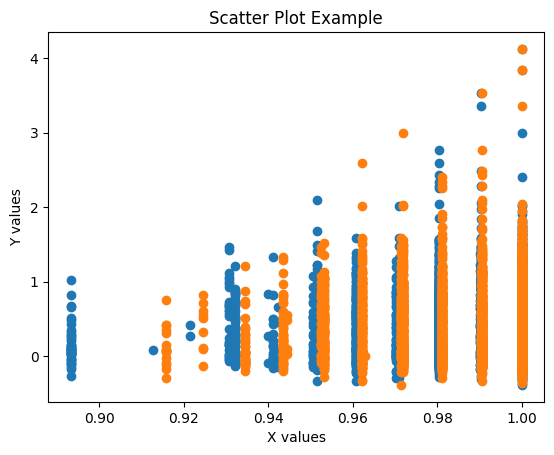

In [84]:
import matplotlib.pyplot as plt

plt.scatter(dice_scores1, df["score"].to_list())
plt.scatter(dice_scores2, df["score"].to_list())

plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Scatter Plot Example')

# Show the plot
plt.show()


In [85]:
fitness_scores = df["score"].to_numpy()
dice_scores1 = np.array(dice_scores1)
dice_scores2 = np.array(dice_scores2)

len(dice_scores1[(fitness_scores > 1) & (dice_scores1 > 0.95)])
len(dice_scores2[(fitness_scores > 1) & (dice_scores2 > 0.95)])

356

In [86]:
from vocabulary_functions import get_family_dictionary, get_mutated, get_parents
import json 

vocab_path = "/cta/share/users/mutbpe/tokenizers/blosum62/uniref50_bpe_51200.json"
# vocab_path = "/cta/share/users/mutbpe/tokenizers/blosum62/uniref50_mutbpe_0.7_3_12_0.05_51200.json"

with open(vocab_path) as f:
    vocab = json.load(f)

all_tokens = list(vocab.keys())
mutated_seqs = []
mut_list = df["mutations"].to_list()
sc_list = df["score"].to_list()
for pos, fst, snd in mut_list:
    sq = str(target_seq)
    mutated_seq = sq[:pos] + snd + sq[pos+1:]
    mutated_seqs.append(mutated_seq)

In [90]:
for i in range(len(mut_list)):
    pos, _, _ = mut_list[i]
    mutseq = mutated_seqs[i]

    mutmer = mutseq[pos-1:pos+2]
    ormer = sq[pos-1:pos+2]

    l1 = len(list(filter(lambda t: mutmer in t, all_tokens)))
    l2 = len(list(filter(lambda t: ormer in t, all_tokens)))
    if sc_list[i] < -0.2:
        print(f"Number of tokens before: {l2}, after: {l1}, score: {sc_list[i]}, mutmer: {mutmer}, ormer: {ormer}")

Number of tokens before: 7, after: 28, score: -0.233353658027674, mutmer: LRH, ormer: LFH
Number of tokens before: 25, after: 3, score: -0.218701879142312, mutmer: CHS, ormer: CLS
Number of tokens before: 0, after: 32, score: -0.329218629048203, mutmer: YTS, ormer: YPS
Number of tokens before: 45, after: 41, score: -0.387684489142223, mutmer: GVL, ormer: GGL
Number of tokens before: 16, after: 13, score: -0.245814406601465, mutmer: FYP, ormer: FHP
Number of tokens before: 18, after: 18, score: -0.205317974242311, mutmer: TKK, ormer: TIK
Number of tokens before: 28, after: 23, score: -0.215532231830538, mutmer: GRP, ormer: GTP
Number of tokens before: 9, after: 25, score: -0.235366338367498, mutmer: EKN, ormer: EPN
Number of tokens before: 5, after: 50, score: -0.367961603384457, mutmer: PSE, ormer: PWE
Number of tokens before: 14, after: 28, score: -0.291792884839761, mutmer: VFL, ormer: VCL
Number of tokens before: 39, after: 21, score: -0.210782009168823, mutmer: LTI, ormer: LGI
Numb